In [1]:
import torch
import matplotlib.pyplot as plt

# Standard backward-mode AD computation in PyTorch

df/dx = tensor(-0.4961)
df/dy = tensor(-0.7441)


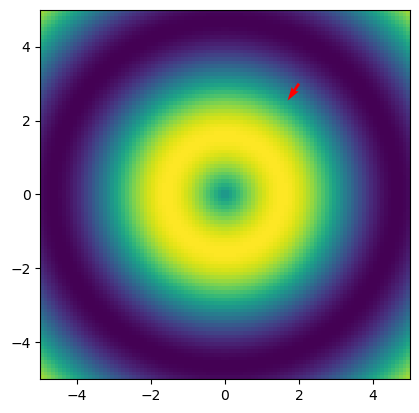

In [2]:
# Define a function
def f(x, y):
    return torch.sin(torch.sqrt(x**2 + y**2))

# Define inputs as torch.Tensor's requiring gradient computation
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

# Define computational graph by computing the value of the function at inputs
f_value = f(x, y)

# Backpropagate through the computational graph to get the gradients w.r.t x and y
f_value.backward()

print('df/dx =', x.grad)
print('df/dy =', y.grad)

# Visualize
x_grid, y_grid = torch.meshgrid(torch.linspace(-5.0, 5.0, 100),
                                torch.linspace(-5.0, 5.0, 100),
                                indexing='xy')
plt.imshow(f(x_grid, y_grid), extent=[-5, 5, -5, 5])
plt.quiver(x.detach(), y.detach(), x.grad, y.grad, color='red')

# Backward-mode AD using VJP

In [3]:
# Define a function
def f(x, y):
    return torch.sin(torch.sqrt(x**2 + y**2))

# Define inputs. requires_grad=True is not necessary here, because we will compute gradients explicitly
x = torch.tensor(2.0)
y = torch.tensor(3.0)

# Apply torch.func.vjp to the function, returning the output and a function to compute vjp
f_value, vjp_f = torch.func.vjp(f, x, y)

# Pass [1.0] tensor to the VJP function effectively to compute the gradient
v = torch.tensor(1.0)
grad_x, grad_y = vjp_f(v)

print('df/dx =', grad_x)
print('df/dy =', grad_y)

df/dx = tensor(-0.4961)
df/dy = tensor(-0.7441)


# Forward-mode AD using JVP

In [4]:
# Define a function
def f(x, y):
    return torch.sin(torch.sqrt(x**2 + y**2))

# Define inputs. requires_grad=True is not necessary here, because we will compute gradients explicitly
x = torch.tensor(2.0)
y = torch.tensor(3.0)

# Pass [1.0, 0.0] tensor to the JVP function effectively to compute df/dx
v = torch.tensor(1.0), torch.tensor(0.0)
f_value, grad_x = torch.func.jvp(f, (x, y), v)

# Pass [0.0, 1.0] tensor to the JVP function effectively to compute df/dy
v = torch.tensor(0.0), torch.tensor(1.0)
f_value, grad_y = torch.func.jvp(f, (x, y), v)

print('df/dx =', grad_x)
print('df/dy =', grad_y)

df/dx = tensor(-0.4961)
df/dy = tensor(-0.7441)


Note that because our function is from $\mathbb{R}^2$ to $\mathbb{R}$, we need to evaluate JVP two times to get the full gradient. In the opposite situation, when calculating the Jacobian of $f: \mathbb{R} \rightarrow \mathbb{R}^2$, the number of operation required will be reversed:

In [5]:
def f(x):
    return torch.sin(x / 2), torch.exp(x)

x = torch.tensor(2.0)

# VJP (backward-mode)
f_value, vjp_f = torch.func.vjp(f, x)
v = torch.tensor(1.0), torch.tensor(0.0)
df1dx, = vjp_f(v)  # Note that output of vjp_f is always a tuple
v = torch.tensor(0.0), torch.tensor(1.0)
df2dx, = vjp_f(v)
print('VJP approach:')
print('df1/dx =', df1dx)
print('df2/dx =', df2dx)

# JVP (forward-mode)
v = torch.tensor(1.0)
f_value, jacobian_f = torch.func.jvp(f, (x,), (v,))  # Note that x and v need to be passed as tuples
print('JVP approach:')
print('df1/dx =', jacobian_f[0])
print('df2/dx =', jacobian_f[1])

VJP approach:
df1/dx = tensor(0.2702)
df2/dx = tensor(7.3891)
JVP approach:
df1/dx = tensor(0.2702)
df2/dx = tensor(7.3891)


See also the full functionality of the [`torch.func`](https://pytorch.org/docs/stable/func.api.html) module, which contains useful functions for calculating Jacobians, higher-order derivatives and vectorizing computations on a function level. 

# Exercises

## Propagation of uncertainty

Consider we have a function $f: \mathbb{R}^2 \rightarrow \mathbb{R}^N$, which can be interpreted as a time evolution of a system parametrized by $\mathrm{x} \in \mathbb{R}^2$:

```python
t = torch.linspace(0, 2*torch.pi, 1000)
def f(x):
    return x[0] * torch.exp(-t) * torch.sin(x[1] * t)
```

If we know the covariance matrix $\Sigma^x$ of parameter $\mathrm{x}$, [we can linearize the function to approximate its covariance matrix](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Non-linear_combinations) between each point in time using the following expression: $\Sigma^f = J \Sigma^x J^\top$, where $J$ is the jacobian of $f$.

1. Calculate the value of $f$ at  $\mathrm{x}_0 = (2.0, 10.0)$.
2. Calculate the covariance matrix $\Sigma^f$ given $\Sigma^x = \begin{bmatrix} 1.0 & 0.0\\ 0.0 & 0.5 \end{bmatrix}$ (hint: look at the functions in [`torch.func`](https://pytorch.org/docs/stable/func.api.html)).
3. Get the standard deviation of $f$ at each point in time by computing the square root of the elements on the diagonal of $\Sigma^f$ and plot it on top of $f(\mathrm{x}_0)$ using `plt.fill_between(t, f(x0) - std, f(x0) + std)`.

### Solution

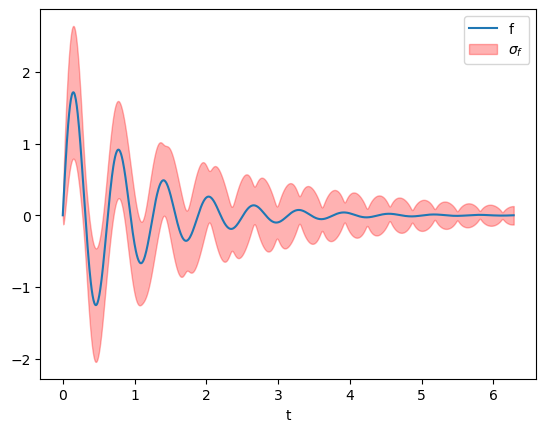

In [6]:
t = torch.linspace(0, 2*torch.pi, 1000)
def f(x):
    return x[0] * torch.exp(-t) * torch.sin(x[1] * t)

x0 = torch.tensor([2.0, 10.0])
covariance_x0 = torch.tensor([
    [1.0, 0.0],
    [0.0, 0.5]
])

jacobian_f = torch.func.jacfwd(f)(x0)
std_f = torch.diag(jacobian_f @ covariance_x0 @ jacobian_f.T)**0.5

plt.plot(t, f(x0), label='f')
plt.fill_between(t, f(x0) - std_f**0.5, f(x0) + std_f**0.5,
                 color='red', alpha=0.3, label='$\\sigma_f$')
plt.legend()
plt.xlabel('t')
plt.show()